# Introduction

In this notebook, we will implement (a variant of) the **U-Net** model, name after its U-shaped architecture, from scratch in **keras**. It is a popular framework for image **segmentation** tasks, with applications in medical imaging and self-driving cars, etc. 

We will also apply our model to a Brain MRI **tumor detection** problem to see how it performs.

**Architecture**

![unet](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

The noteable features of the network include many **convolution + relu** and **max pooling** layers in the encoder (first half) to contextualise the inputs. The decoder (second half) on the other hand makes use of **transpose convolutions** to increase the images sizes back to that of the input (since the input and output sizes have to match). 

The drawback to this is a loss of **spatial information** due to the shrinking image size. To overcome this, the model uses **skip connections** to relay spatial information from the encoder to the decoder after every block of convolutions. This results in a high resolution and high accuracy segmentation method whilst keeping the computational cost relatively low.

**Libraries**

In [1]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import time
import warnings
warnings.filterwarnings("ignore")
import gc
import os
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.color import rgb2gray
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label


# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing
from keras.utils.vis_utils import plot_model

**Reproducibility**

In [2]:
# Set random seeds
def set_seed(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed()

# U-Net

You can find the original paper [here](https://arxiv.org/pdf/1505.04597.pdf) (from 2015).

**Encoder**

In [3]:
def conv_block(inputs=None, n_filters=64, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    
    # Convolutional layers
    conv = layers.Conv2D(n_filters,
                  kernel_size = (3, 3),
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(inputs)
    conv = layers.Conv2D(n_filters,
                  kernel_size = (3, 3),
                  activation = None,
                  padding = 'same',
                  kernel_initializer = 'he_normal')(conv)
    skip_connection = conv
    conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv)
    else:
        next_layer = conv
    
    return next_layer, skip_connection

**Decoder**

In [4]:
def upsampling_block(expansive_input, contractive_input, n_filters=64):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    # Transpose convolution
    up = layers.Conv2DTranspose(
                 n_filters,
                 kernel_size = (2, 2),
                 strides = (2, 2),
                 padding = 'same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = layers.concatenate([up, contractive_input], axis=3)
    conv = layers.Conv2D(n_filters,
                 kernel_size = (3, 3),
                 activation = 'relu',
                 padding = 'same',
                 kernel_initializer = 'he_normal')(merge)
    conv = layers.Conv2D(n_filters,
                 kernel_size = (3, 3),
                 activation = None,
                 padding = 'same',
                 kernel_initializer = 'he_normal')(conv)
    conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    return conv

**Model**

In [5]:
# 23 layer CNN
def build_unet(input_size=(256, 256, 3), n_filters=64, n_classes=1):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    
    # Input layer
    inputs = layers.Input(input_size)
    
    # Encoder (double the number of filters at each step)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters)
    cblock5 = conv_block(cblock4[0], 16*n_filters, max_pooling=False) 
    
    # Decoder (halve the number of filters at each step)
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  4*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    # 1x1 convolution
    conv10 = layers.Conv2D(filters = n_classes,
                 kernel_size = (1, 1),
                 activation = 'sigmoid',    # use softmax if n_classes>1
                 padding = 'same')(ublock9)

    model = keras.Model(inputs=inputs, outputs=conv10)

    return model

**Alternative implementation**

In [6]:
# Long form
def build_unet_alt(input_size=(256, 256, 3), n_filters=64, n_classes=1):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    
    # Input layer
    inputs = layers.Input(input_size)
    
    # Block 1 (encoder)
    conv1 = layers.Conv2D(n_filters,
                  kernel_size = (3, 3),
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(inputs)
    conv1 = layers.Conv2D(n_filters,
                  kernel_size = (3, 3),
                  activation = None,
                  padding = 'same',
                  kernel_initializer = 'he_normal')(conv1)
    bn1 = layers.BatchNormalization(axis=3)(conv1)
    act1 = layers.Activation('relu')(bn1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(act1)
    
    # Block 2 (encoder)
    conv2 = layers.Conv2D(2*n_filters,
                  kernel_size = (3, 3),
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(pool1)
    conv2 = layers.Conv2D(2*n_filters,
                  kernel_size = (3, 3),
                  activation = None,
                  padding = 'same',
                  kernel_initializer = 'he_normal')(conv2)
    bn2 = layers.BatchNormalization(axis=3)(conv2)
    act2 = layers.Activation('relu')(bn2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(act2)
    
    # Block 3 (encoder)
    conv3 = layers.Conv2D(4*n_filters,
                  kernel_size = (3, 3),
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(pool2)
    conv3 = layers.Conv2D(4*n_filters,
                  kernel_size = (3, 3),
                  activation = None,
                  padding = 'same',
                  kernel_initializer = 'he_normal')(conv3)
    bn3 = layers.BatchNormalization(axis=3)(conv3)
    act3 = layers.Activation('relu')(bn3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(act3)
    
    # Block 4 (encoder)
    conv4 = layers.Conv2D(8*n_filters,
                  kernel_size = (3, 3),
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(pool3)
    conv4 = layers.Conv2D(8*n_filters,
                  kernel_size = (3, 3),
                  activation = None,
                  padding = 'same',
                  kernel_initializer = 'he_normal')(conv4)
    bn4 = layers.BatchNormalization(axis=3)(conv4)
    act4 = layers.Activation('relu')(bn4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(act4)
    
    # Block 5 (bottleneck)
    conv5 = layers.Conv2D(16*n_filters,
                  kernel_size = (3, 3),
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(pool4)
    conv5 = layers.Conv2D(16*n_filters,
                  kernel_size = (3, 3),
                  activation = None,
                  padding = 'same',
                  kernel_initializer = 'he_normal')(conv5)
    bn5 = layers.BatchNormalization(axis=3)(conv5)
    act5 = layers.Activation('relu')(bn5)
    
    # Block 6 (decoder)
    up6 = layers.Conv2DTranspose(
                 8*n_filters,
                 kernel_size = (2, 2),
                 strides = (2, 2),
                 padding = 'same')(act5)
    merge6 = layers.concatenate([up6, conv4], axis=3)
    conv6 = layers.Conv2D(8*n_filters,
                 kernel_size = (3, 3),
                 activation = 'relu',
                 padding = 'same',
                 kernel_initializer = 'he_normal')(merge6)
    conv6 = layers.Conv2D(8*n_filters,
                 kernel_size = (3, 3),
                 activation = None,
                 padding = 'same',
                 kernel_initializer = 'he_normal')(conv6)
    bn6 = layers.BatchNormalization(axis=3)(conv6)
    act6 = layers.Activation('relu')(bn6)
    
    # Block 7 (decoder)
    up7 = layers.Conv2DTranspose(
                 4*n_filters,
                 kernel_size = (2, 2),
                 strides = (2, 2),
                 padding = 'same')(act6)
    merge7 = layers.concatenate([up7, conv3], axis=3)
    conv7 = layers.Conv2D(4*n_filters,
                 kernel_size = (3, 3),
                 activation = 'relu',
                 padding = 'same',
                 kernel_initializer = 'he_normal')(merge7)
    conv7 = layers.Conv2D(4*n_filters,
                 kernel_size = (3, 3),
                 activation = None,
                 padding = 'same',
                 kernel_initializer = 'he_normal')(conv7)
    bn7 = layers.BatchNormalization(axis=3)(conv7)
    act7 = layers.Activation('relu')(bn7)
    
    # Block 8 (decoder)
    up8 = layers.Conv2DTranspose(
                 2*n_filters,
                 kernel_size = (2, 2),
                 strides = (2, 2),
                 padding = 'same')(act7)
    merge8 = layers.concatenate([up8, conv2], axis=3)
    conv8 = layers.Conv2D(2*n_filters,
                 kernel_size = (3, 3),
                 activation = 'relu',
                 padding = 'same',
                 kernel_initializer = 'he_normal')(merge8)
    conv8 = layers.Conv2D(2*n_filters,
                 kernel_size = (3, 3),
                 activation = None,
                 padding = 'same',
                 kernel_initializer = 'he_normal')(conv8)
    bn8 = layers.BatchNormalization(axis=3)(conv8)
    act8 = layers.Activation('relu')(bn8)
    
    # Block 9 (decoder)
    up9 = layers.Conv2DTranspose(
                 n_filters,
                 kernel_size = (2, 2),
                 strides = (2, 2),
                 padding = 'same')(act8)
    merge9 = layers.concatenate([up9, conv1], axis=3)
    conv9 = layers.Conv2D(n_filters,
                 kernel_size = (3, 3),
                 activation = 'relu',
                 padding = 'same',
                 kernel_initializer = 'he_normal')(merge9)
    conv9 = layers.Conv2D(n_filters,
                 kernel_size = (3, 3),
                 activation = None,
                 padding = 'same',
                 kernel_initializer = 'he_normal')(conv9)
    bn9 = layers.BatchNormalization(axis=3)(conv9)
    act9 = layers.Activation('relu')(bn9)
    
    # Output layer (1x1 convolution)
    conv10 = layers.Conv2D(filters = n_classes,
                 kernel_size = (1, 1),
                 activation = 'sigmoid',   # use softmax if n_classes>1
                 padding = 'same')(act9)

    model = keras.Model(inputs=[inputs], outputs=[conv10])

    return model

**Model summary**

In [7]:
# Model summary
model=build_unet()
model.summary()

2022-06-13 14:04:40.174456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 14:04:40.301817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 14:04:40.303006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 14:04:40.305129: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

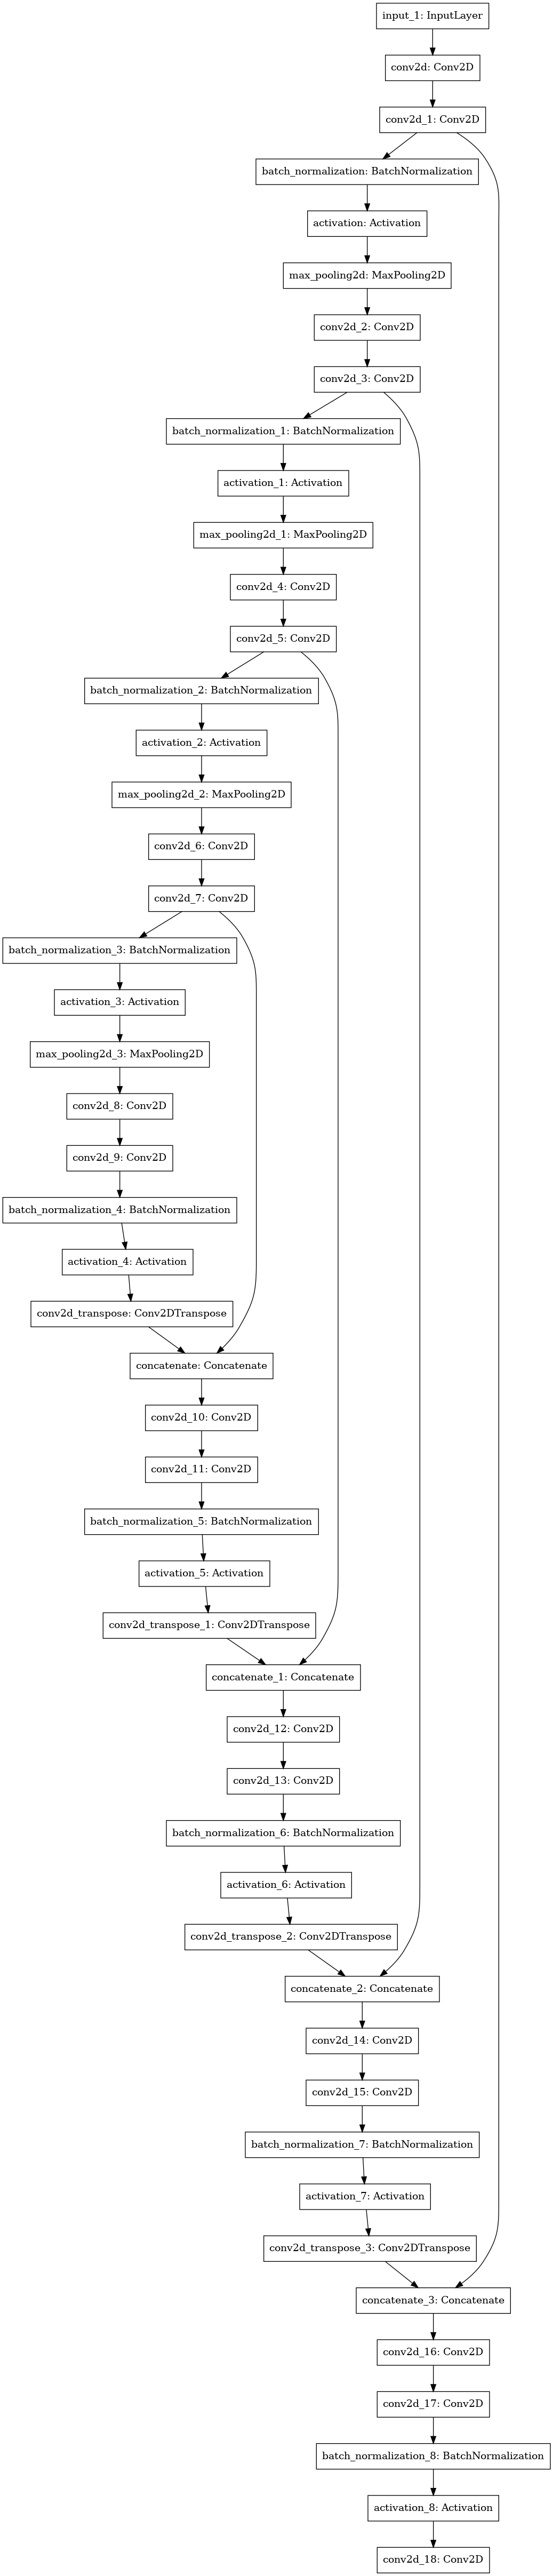

In [8]:
# Plot model architecture
plot_model(model)

# Application: Tumor detection

**Get training files**

In [9]:
train_files = []
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

**Preview some images**

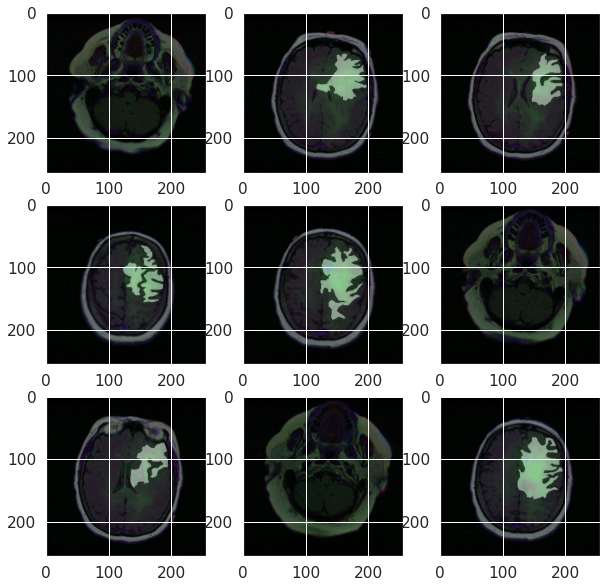

In [10]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

**Split data**

In [11]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


**Data generator**

In [12]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

**Metrics**

In [13]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

**Config**

In [14]:
EPOCHS = 150
BATCH_SIZE = 32
learning_rate = 1e-3
im_width = 256
im_height = 256

**Training**

In [15]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    #callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.


2022-06-13 14:04:53.107349: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-06-13 14:04:56.976501: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


89/88 [==============================] - ETA: 0s - loss: 0.8453 - binary_accuracy: 0.9209 - iou: 0.0875 - dice_coef: 0.1546Found 708 validated image filenames.
Found 708 validated image filenames.
88/88 [==============================] - 140s 1s/step - loss: 0.8453 - binary_accuracy: 0.9209 - iou: 0.0875 - dice_coef: 0.1546 - val_loss: 0.6213 - val_binary_accuracy: 0.9798 - val_iou: 0.2347 - val_dice_coef: 0.3748
Epoch 2/150
88/88 [==============================] - 94s 1s/step - loss: 0.5357 - binary_accuracy: 0.9905 - iou: 0.3137 - dice_coef: 0.4655 - val_loss: 0.9724 - val_binary_accuracy: 0.1597 - val_iou: 0.0143 - val_dice_coef: 0.0281
Epoch 3/150
88/88 [==============================] - 94s 1s/step - loss: 0.3799 - binary_accuracy: 0.9934 - iou: 0.4613 - dice_coef: 0.6213 - val_loss: 0.8502 - val_binary_accuracy: 0.8833 - val_iou: 0.0838 - val_dice_coef: 0.1524
Epoch 4/150
88/88 [==============================] - 94s 1s/step - loss: 0.3524 - binary_accuracy: 0.9938 - iou: 0.4921 -

**Learning curves**

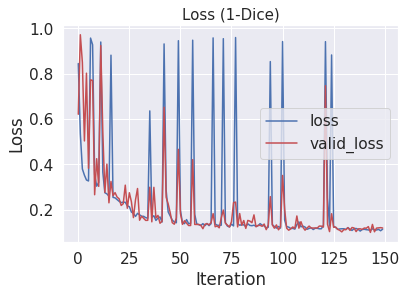

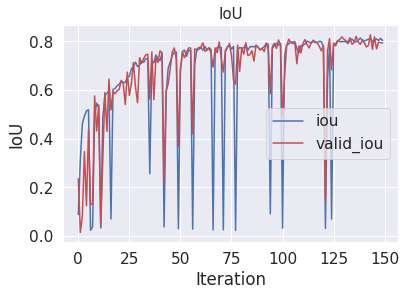

In [16]:
plt.figure(1)
plt.plot(history.history['loss'],'b-', label='loss')
plt.plot(history.history['val_loss'], 'r-', label='valid_loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss (1-Dice)', fontsize = 15)
plt.legend()

plt.figure(2)
plt.plot(history.history['iou'], 'b-', label='iou')
plt.plot(history.history['val_iou'], 'r-', label='valid_iou')
plt.xlabel('Iteration')
plt.ylabel('IoU')
plt.title('IoU', fontsize = 15)
plt.legend()
plt.show()

**Evaluate**

In [17]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)

print("Test loss: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 8s 677ms/step - loss: 0.1302 - binary_accuracy: 0.9975 - iou: 0.7757 - dice_coef: 0.8720
Test loss:  0.1301841288805008
Test IOU:  0.9974963068962097
Test Dice Coefficent:  0.7757408618927002


**Plot predictions**

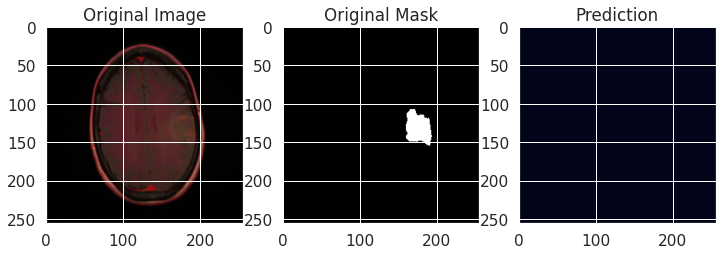

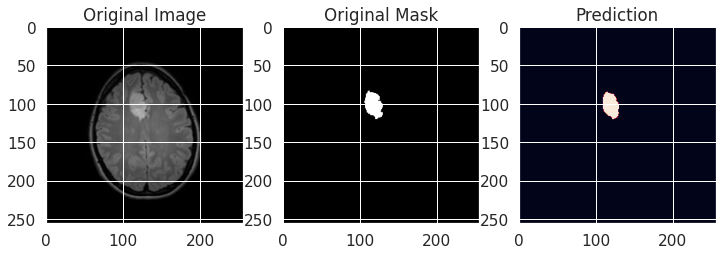

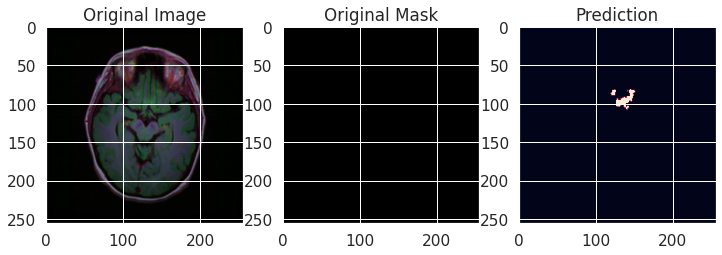

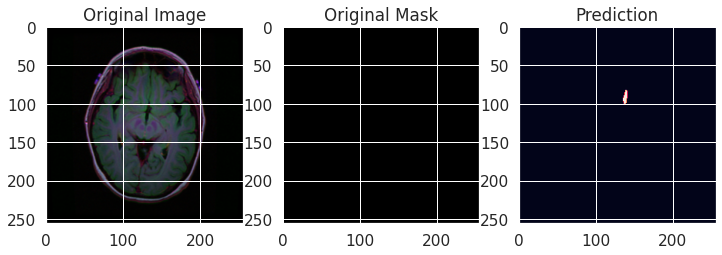

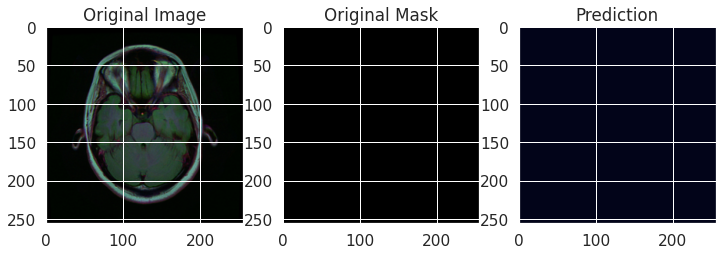

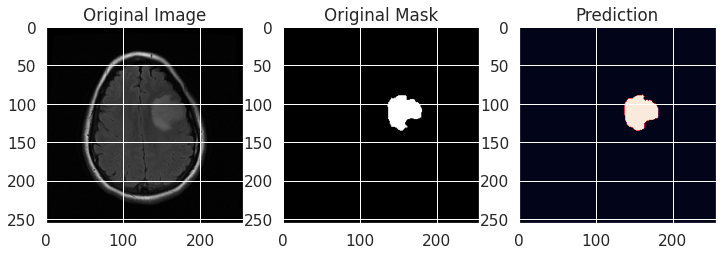

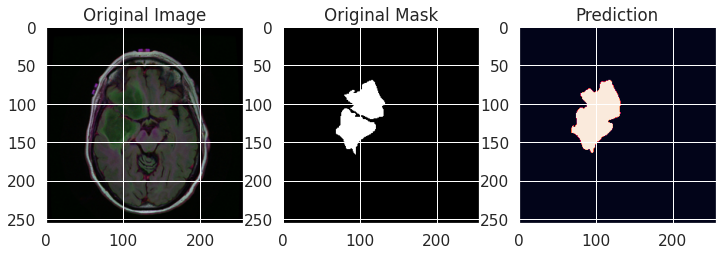

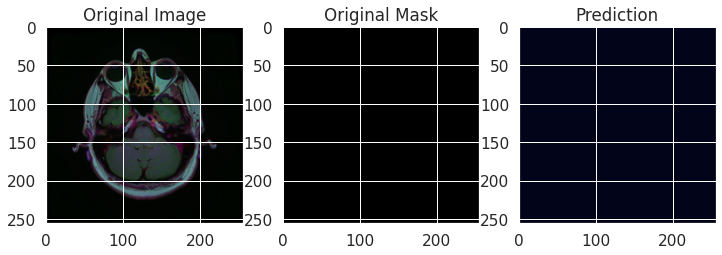

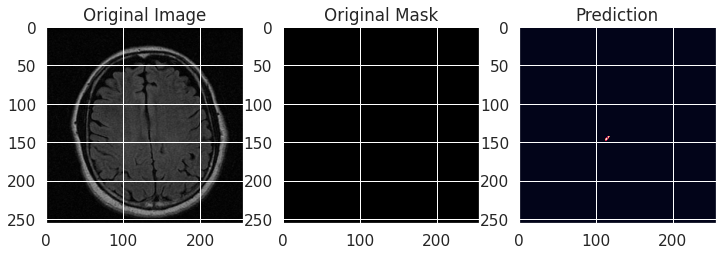

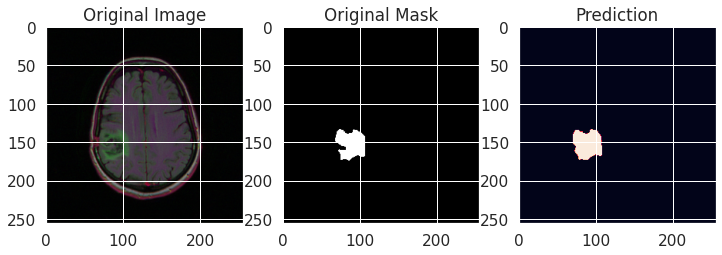

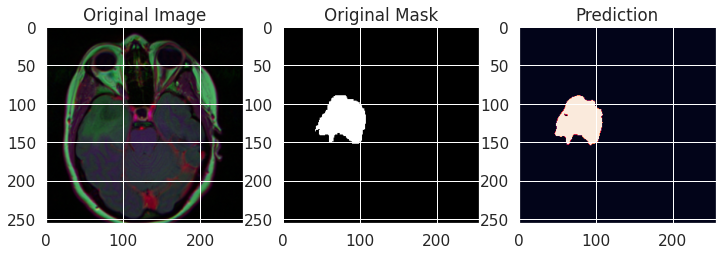

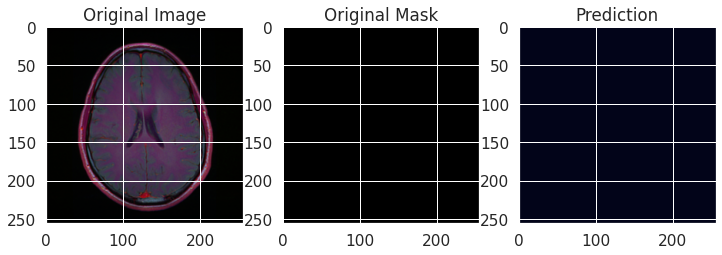

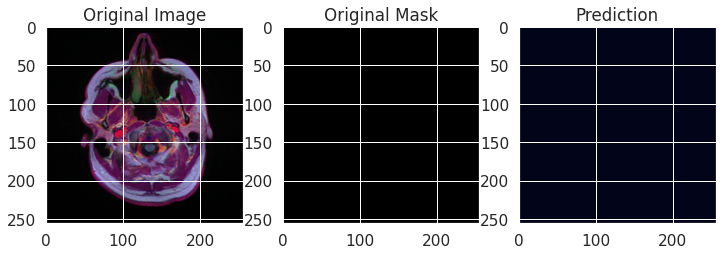

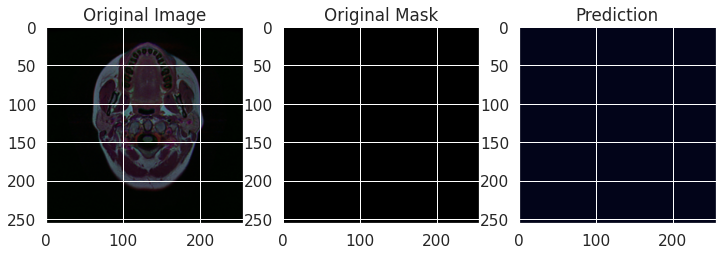

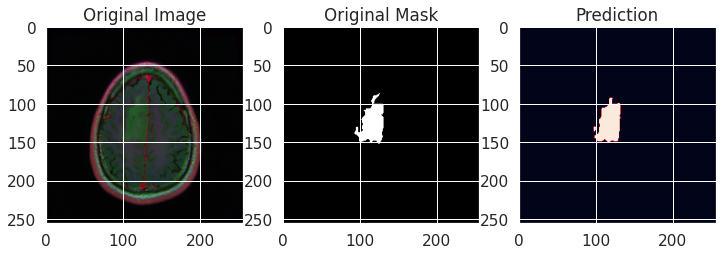

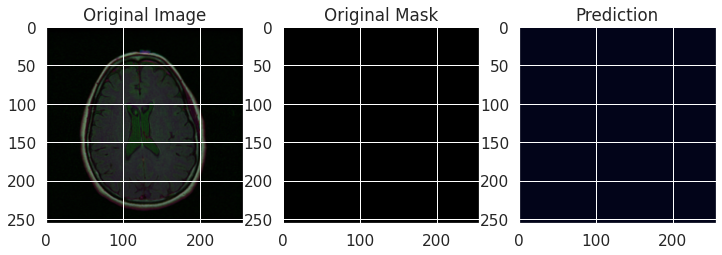

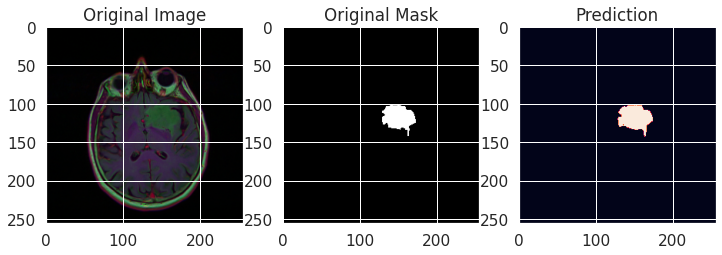

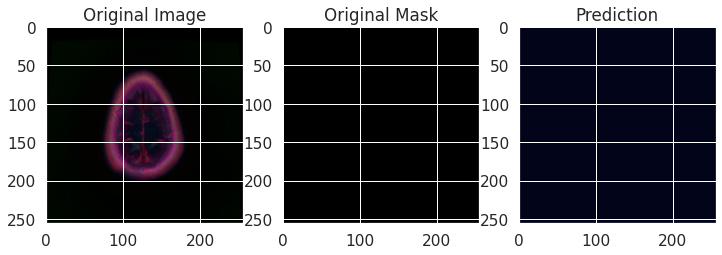

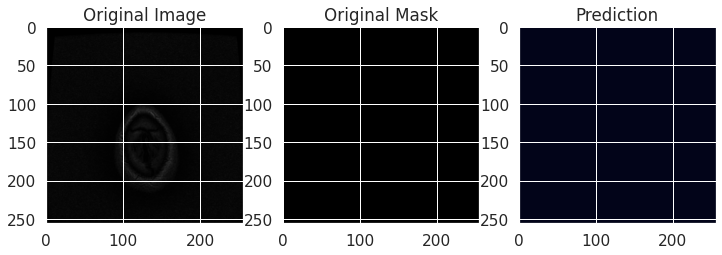

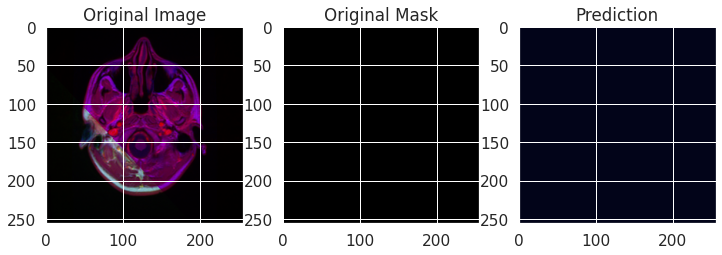

In [18]:
for i in range(20):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

**Acknowledgments:**
* [Brain MRI Segmentation| Using Unet | Keras](https://www.kaggle.com/code/monkira/brain-mri-segmentation-using-unet-keras) by [MonKira](https://www.kaggle.com/monkira).
* [Convolutional Neural Networks](https://www.coursera.org/learn/convolutional-neural-networks) by [Andrew NG](https://en.wikipedia.org/wiki/Andrew_Ng).

Thanks for reading!